In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load the data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

In [3]:
# Preprocess - Round to nearest 5 minutes
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')

# Filter out rows where mg/dl is > 400 or missing values
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])

# Drop duplicates and sort
cgm_data = cgm_data.drop_duplicates(subset='date').reset_index(drop=True)
cgm_data = cgm_data.sort_values(by='date').reset_index(drop=True)

In [4]:
# Generate AR Features (using past 12 readings as input)
num_lags = 12 # Using the past 12 values
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

cgm_data = cgm_data.dropna().reset_index(drop=True)

In [5]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Feed Forward Neural Network with Only Blood Glucose

In [6]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8816/8816 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 4222.6851 - mae: 41.6914 - val_loss: 463.2515 - val_mae: 14.7101
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 1089.2852 - mae: 24.4911 - val_loss: 501.4056 - val_mae: 15.8736
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1019.8597 - mae: 23.5240 - val_loss: 451.0280 - val_mae: 14.6674
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 960.2903 - mae: 22.7634 - val_loss: 429.7136 - val_mae: 14.2608
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 922.6578 - mae: 22.1724 - val_loss: 428.6378 - val_mae: 14.2735
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 374.4217 - mae: 13.4997
Test Loss: 361.8794250488281, Test MAE: 13.154582977294922
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [7]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 19.023136216451483


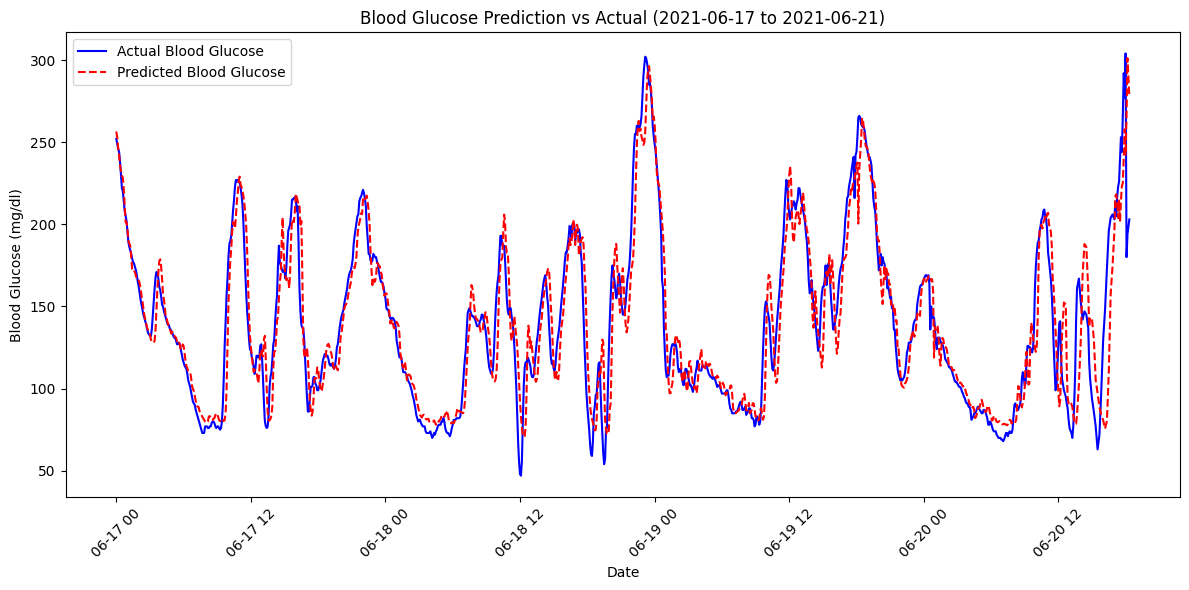

In [8]:
import matplotlib.pyplot as plt

# Add 'date' to the test data for plotting
test_dates = cgm_data['date'][train_size:].reset_index(drop=True)

# Function to plot actual vs predicted values for a specific week
def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    # Create a DataFrame for easier manipulation
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    # Filter data for the given date range
    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify the start and end date for the week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions for the specified week
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)


6

In [9]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 6  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [10]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8816/8816 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 4831.4736 - mae: 47.5923 - val_loss: 1029.6627 - val_mae: 23.0000
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1792.2770 - mae: 31.7806 - val_loss: 1016.7770 - val_mae: 22.6980
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 1727.1327 - mae: 31.0934 - val_loss: 973.1716 - val_mae: 22.0632
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 1663.1899 - mae: 30.4514 - val_loss: 936.5801 - val_mae: 21.6885
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 1623.0469 - mae: 29.9782 - val_loss: 961.0287 - val_mae: 22.1564
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 860.8783 - mae: 21.0596
Test Loss: 832.6141357421875, Test MAE: 20.666168212890625
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [11]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 28.855056799676614


9

In [12]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 9  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [13]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 5389.3398 - mae: 51.5523 - val_loss: 1660.2958 - val_mae: 30.1552
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 2230.7991 - mae: 35.7590 - val_loss: 1546.8431 - val_mae: 28.8123
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2151.7324 - mae: 34.9617 - val_loss: 1496.6863 - val_mae: 28.1627
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2085.0864 - mae: 34.3958 - val_loss: 1714.3561 - val_mae: 30.9218
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 2046.4032 - mae: 34.0006 - val_loss: 1507.1779 - val_mae: 28.3739
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1366.8375 - mae: 27.0570
Test Loss: 1324.0677490234375, Test MAE: 26.637035369873047
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


In [14]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 36.38773985932795


12

In [15]:
# Create labels for prediction (15, 30, 45, 60 mins into the future)
forecast_horizon = 12  # 15 minutes (3 readings ahead assuming 5-min intervals)
cgm_data['target'] = cgm_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to shifting
cgm_data = cgm_data.dropna().reset_index(drop=True)

# Split into features and labels
X = cgm_data[[f'lag_{i}' for i in range(1, num_lags + 1)]].values
y = cgm_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [16]:
# Build the neural network model
model = Sequential([
    Dense(64, activation='relu', input_dim=num_lags),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


8815/8815 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 5611.3467 - mae: 53.8965 - val_loss: 2235.7952 - val_mae: 35.5973
Epoch 2/5
8815/8815 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - loss: 2707.6223 - mae: 39.8164 - val_loss: 2093.0190 - val_mae: 34.1657
Epoch 3/5
8815/8815 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 2631.2122 - mae: 39.1783 - val_loss: 2099.1780 - val_mae: 34.3317
Epoch 4/5
8815/8815 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2568.4126 - mae: 38.5894 - val_loss: 2145.4578 - val_mae: 34.7159
Epoch 5/5
8815/8815 ━━━━━━━━━━━━━━━━━━━━ 38s 2ms/step - loss: 2544.6555 - mae: 38.2856 - val_loss: 2182.8159 - val_mae: 34.9393
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1969.0051 - mae: 33.0819
Test Loss: 1865.306640625, Test MAE: 32.056251525878906
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


In [17]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


Root Mean Squared Error (RMSE): 43.18918088365147


Feed Forward Neural Network with Blood Glucose and Bolus

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error

# Load CGM and Bolus data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

In [19]:
# Preprocess CGM data
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Preprocess Bolus data
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for CGM (past glucose readings)
num_lags = 12  # Number of past readings to use
for lag in range(1, num_lags + 1):
    merged_data[f'lag_{lag}'] = merged_data['mg/dl'].shift(lag)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
              'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
              'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-19-b23c5d981a10>:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [20]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 3  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-20-2e8ff43a49a4>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)


In [21]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 3208.8389 - mae: 35.7905 - val_loss: 494.3274 - val_mae: 15.5576
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 988.2192 - mae: 23.1684 - val_loss: 436.6945 - val_mae: 14.3506
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 919.9921 - mae: 22.2553 - val_loss: 406.7596 - val_mae: 13.6356
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 884.6113 - mae: 21.7544 - val_loss: 469.4740 - val_mae: 15.3104
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 848.1674 - mae: 21.2835 - val_loss: 403.9361 - val_mae: 13.5843
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 360.1696 - mae: 13.0592
Test Loss: 371.7409362792969, Test MAE: 13.280437469482422
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Root Mean Squared Error (RMSE): 19.28057831244034


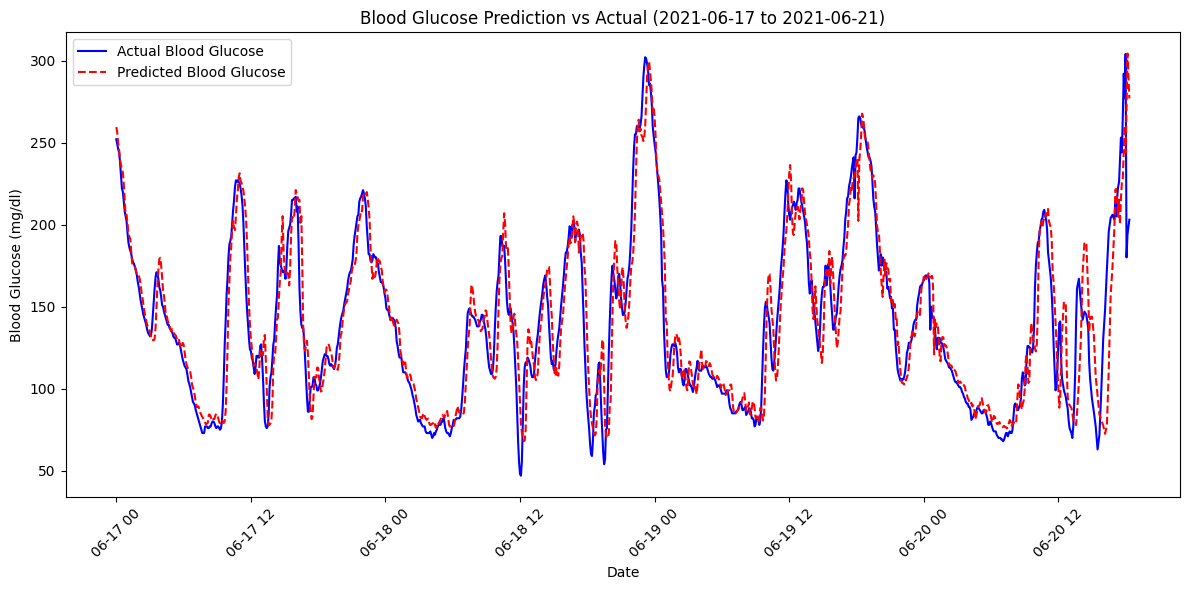

In [22]:
def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify dates for a week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)

6

In [23]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 6  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [24]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 3768.3645 - mae: 41.3613 - val_loss: 972.2068 - val_mae: 22.2252
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 1528.3599 - mae: 29.1567 - val_loss: 953.7582 - val_mae: 21.9312
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - loss: 1458.1227 - mae: 28.3679 - val_loss: 940.9979 - val_mae: 21.7051
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - loss: 1415.0209 - mae: 27.9019 - val_loss: 898.1700 - val_mae: 20.9807
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 1395.9301 - mae: 27.5806 - val_loss: 933.9382 - val_mae: 21.7227
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 848.4989 - mae: 20.8301
Test Loss: 841.6227416992188, Test MAE: 20.764007568359375
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Root Mean Squared Error (RMSE): 29.01075434488825


9

In [25]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 9  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [26]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 4381.5151 - mae: 46.4879 - val_loss: 1563.2008 - val_mae: 29.3037
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2138.4131 - mae: 34.8695 - val_loss: 1646.0139 - val_mae: 29.9962
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 41s 2ms/step - loss: 2065.0049 - mae: 34.1993 - val_loss: 1507.6720 - val_mae: 28.3568
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 42s 2ms/step - loss: 2055.0940 - mae: 34.0544 - val_loss: 1489.6880 - val_mae: 27.8448
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1997.1716 - mae: 33.5128 - val_loss: 1567.5708 - val_mae: 28.8454
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1424.5789 - mae: 27.5055
Test Loss: 1377.7816162109375, Test MAE: 27.023265838623047
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
Root Mean Squared Error (RMSE): 37.11847879944151


12

In [27]:
# Generate target variable (15-minute ahead glucose levels)
forecast_horizon = 12  # Predict 15 minutes ahead
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaNs introduced by lagging and shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features (X) and target (y)
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test (80% train, 20% test by time order)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [28]:
# Build the neural network model
model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Add a function to plot actual vs predicted
import matplotlib.pyplot as plt

test_dates = merged_data['date'][train_size:].reset_index(drop=True)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - loss: 4802.9287 - mae: 49.6370 - val_loss: 2172.8267 - val_mae: 35.1580
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - loss: 2569.6816 - mae: 38.6595 - val_loss: 2192.0876 - val_mae: 35.2198
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - loss: 2516.7502 - mae: 38.1616 - val_loss: 2106.3328 - val_mae: 34.2090
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - loss: 2487.5027 - mae: 37.8428 - val_loss: 2121.6455 - val_mae: 34.4699
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 2443.2761 - mae: 37.5589 - val_loss: 2020.8022 - val_mae: 33.6189
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1879.9138 - mae: 32.6288
Test Loss: 1896.9080810546875, Test MAE: 32.877620697021484
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Root Mean Squared Error (RMSE): 43.55350245704112


LSTM with Blood Glucose and Bolus Data

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load CGM and Bolus data (same preprocessing steps as before)
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')

# Preprocess CGM data
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Preprocess Bolus data
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for CGM and Bolus variables
num_lags = 12
for lag in range(1, num_lags + 1):
    merged_data[f'lag_{lag}'] = merged_data['mg/dl'].shift(lag)

bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput', 'recommended.carb',
              'recommended.net', 'recommended.correction', 'insulinSensitivityFactor',
              'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)



<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-29-e2667385971b>:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [30]:
# Generate target variable
forecast_horizon = 3
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

<ipython-input-30-4728be9a6491>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)


In [31]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 138s 15ms/step - loss: 18658.0449 - mae: 113.8294 - val_loss: 1719.3987 - val_mae: 27.7021
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 135s 15ms/step - loss: 1176.4913 - mae: 23.7938 - val_loss: 456.9405 - val_mae: 14.6432
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 134s 15ms/step - loss: 743.5718 - mae: 19.7896 - val_loss: 404.2505 - val_mae: 13.2104
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 136s 15ms/step - loss: 708.1678 - mae: 19.3019 - val_loss: 395.6833 - val_mae: 13.6508
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 136s 15ms/step - loss: 701.2607 - mae: 19.0943 - val_loss: 389.5351 - val_mae: 13.5542
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - loss: 686.3608 - mae: 18.8951 - val_loss: 389.5669 - val_mae: 13.5603
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 136s 15ms/step - loss: 686.2180 - mae: 18.8343 - val_loss: 379.4385 - val_mae: 12.9278
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 133s 15ms/step - loss: 663.4371 - mae: 18.5411 - v

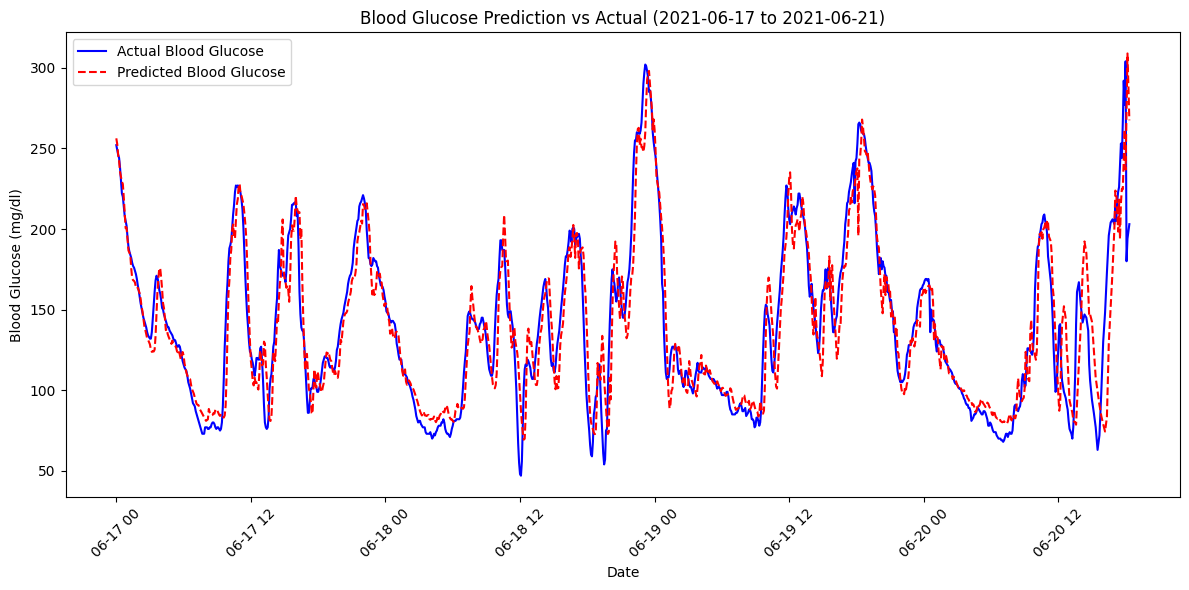

In [32]:
# Plot predictions vs actual for a given week
test_dates = merged_data['date'][train_size:].reset_index(drop=True)

def plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date):
    results = pd.DataFrame({
        'date': test_dates,
        'actual': y_test,
        'predicted': predictions.flatten()
    })

    week_data = results[(results['date'] >= start_date) & (results['date'] <= end_date)]

    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], week_data['actual'], label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], week_data['predicted'], label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title(f'Blood Glucose Prediction vs Actual ({start_date} to {end_date})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Specify dates for a week
start_date = '2021-06-17'
end_date = '2021-06-21'

# Plot predictions
plot_predictions_for_week(test_dates, y_test, predictions, start_date, end_date)

6

In [33]:
# Generate target variable
forecast_horizon = 6
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 130s 14ms/step - loss: 18258.7012 - mae: 112.8764 - val_loss: 2104.9214 - val_mae: 32.5786
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 14ms/step - loss: 1648.4973 - mae: 29.5899 - val_loss: 1034.7224 - val_mae: 23.0330
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 15ms/step - loss: 1240.2203 - mae: 25.8874 - val_loss: 891.9630 - val_mae: 20.9257
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 15ms/step - loss: 1205.9197 - mae: 25.4115 - val_loss: 895.3320 - val_mae: 20.7217
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - loss: 1188.2634 - mae: 25.1940 - val_loss: 935.8743 - val_mae: 21.7545
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 125s 14ms/step - loss: 1176.4811 - mae: 25.0643 - val_loss: 878.5869 - val_mae: 20.4041
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 148s 15ms/step - loss: 1167.3693 - mae: 24.8644 - val_loss: 851.8575 - val_mae: 20.0927
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - loss: 1160.1787 - mae: 24.7

9

In [35]:
# Generate target variable
forecast_horizon = 9
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [36]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 133s 15ms/step - loss: 18923.0469 - mae: 115.3567 - val_loss: 2646.1851 - val_mae: 38.3781
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 14ms/step - loss: 2187.8699 - mae: 34.9523 - val_loss: 1540.3292 - val_mae: 29.2041
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 15ms/step - loss: 1806.6742 - mae: 31.7421 - val_loss: 1595.0317 - val_mae: 28.7814
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 126s 14ms/step - loss: 1768.6677 - mae: 31.3000 - val_loss: 1485.4974 - val_mae: 27.9742
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 15ms/step - loss: 1741.7626 - mae: 31.0529 - val_loss: 1504.2954 - val_mae: 29.0910
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 128s 15ms/step - loss: 1718.4398 - mae: 30.8664 - val_loss: 1455.5416 - val_mae: 27.4606
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 14ms/step - loss: 1712.3840 - mae: 30.7397 - val_loss: 1516.8341 - val_mae: 28.3872
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 15ms/step - loss: 1703.9355 - mae:

12

In [37]:
# Generate target variable
forecast_horizon = 12
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN
merged_data = merged_data.dropna().reset_index(drop=True)

# Define features and labels
feature_columns = [col for col in merged_data.columns if 'lag' in col]
X = merged_data[feature_columns].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Reshape input data for LSTM
X = X.reshape((X.shape[0], num_lags, int(X.shape[1] / num_lags)))

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [38]:
# Build LSTM model
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 15ms/step - loss: 18364.9473 - mae: 113.3965 - val_loss: 2969.3572 - val_mae: 41.8126
Epoch 2/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 149s 16ms/step - loss: 2620.3779 - mae: 38.9737 - val_loss: 2059.4785 - val_mae: 33.5635
Epoch 3/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 190s 15ms/step - loss: 2303.6594 - mae: 36.3487 - val_loss: 2118.5530 - val_mae: 34.1370
Epoch 4/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 143s 15ms/step - loss: 2270.5034 - mae: 36.0072 - val_loss: 1991.2275 - val_mae: 33.4764
Epoch 5/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 142s 15ms/step - loss: 2237.3665 - mae: 35.7395 - val_loss: 2037.6029 - val_mae: 32.8479
Epoch 6/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 140s 15ms/step - loss: 2231.4927 - mae: 35.6299 - val_loss: 1962.7422 - val_mae: 33.0812
Epoch 7/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 131s 15ms/step - loss: 2198.3967 - mae: 35.4068 - val_loss: 1969.0092 - val_mae: 33.0154
Epoch 8/10
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 132s 15ms/step - loss: 2197.6455 - mae:

CNN

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
import matplotlib.pyplot as plt

# Load CGM data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

# Preprocess CGM data - Round to nearest 5 minutes and filter
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Generate lag features for CGM data
num_lags = 12  # Using the past 12 readings as features
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
              'recommended.carb', 'recommended.net', 'recommended.correction',
              'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaN due to shifting
merged_data = merged_data.dropna().reset_index(drop=True)



<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-39-1cd8221e526c>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [40]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [41]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 123s 14ms/step - loss: 2437.6016 - mae: 33.4955 - val_loss: 886.0685 - val_mae: 23.0652
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 138s 13ms/step - loss: 1040.0734 - mae: 23.6643 - val_loss: 733.6315 - val_mae: 20.4699
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 137s 13ms/step - loss: 971.1092 - mae: 22.8235 - val_loss: 942.8793 - val_mae: 24.0319
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 13ms/step - loss: 955.8120 - mae: 22.6333 - val_loss: 953.5220 - val_mae: 24.0957
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 141s 13ms/step - loss: 938.2834 - mae: 22.4450 - val_loss: 980.8089 - val_mae: 24.3927
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2239.5540 - mae: 27.4929
Test Loss: 7019.32177734375, Test MAE: 43.3645133972168
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Root Mean Squared Error (RMSE): 83.78136499995723


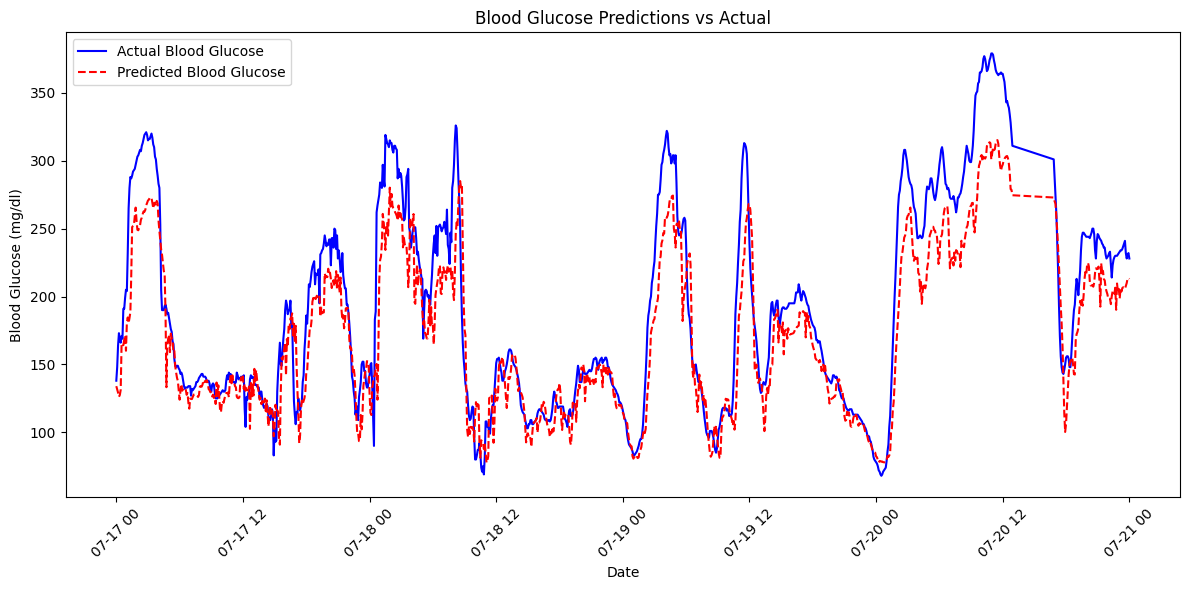

In [42]:
# Plot actual vs predicted for a specific week
def plot_predictions_for_week(data, predictions, actual, start_date, end_date):
    # Filter the test data for the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Get aligned predictions and actual values
    aligned_predictions = predictions[:len(week_data)]
    aligned_actual = actual[:len(week_data)]

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], aligned_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], aligned_predictions, label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title('Blood Glucose Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for a specific week
plot_predictions_for_week(merged_data[train_size:], predictions, y_test, '2021-07-17', '2021-07-21')

6

In [43]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 6  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [44]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 117s 13ms/step - loss: 2896.5425 - mae: 37.7854 - val_loss: 1422.1222 - val_mae: 28.7920
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 145s 13ms/step - loss: 1453.7220 - mae: 28.2748 - val_loss: 1299.9434 - val_mae: 26.9937
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 139s 13ms/step - loss: 1409.6722 - mae: 27.7422 - val_loss: 1412.2264 - val_mae: 28.8731
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 139s 13ms/step - loss: 1373.1589 - mae: 27.4366 - val_loss: 1562.1262 - val_mae: 30.6252
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 146s 13ms/step - loss: 1378.4863 - mae: 27.4474 - val_loss: 1354.7864 - val_mae: 27.9023
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 1505.2413 - mae: 27.7429
Test Loss: 2458.376953125, Test MAE: 32.67076110839844
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
Root Mean Squared Error (RMSE): 49.582020107555074


9

In [45]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 9  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [46]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 121s 14ms/step - loss: 3460.0073 - mae: 42.7200 - val_loss: 1944.3345 - val_mae: 33.2273
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 123s 14ms/step - loss: 2028.0264 - mae: 33.8991 - val_loss: 1626.8336 - val_mae: 29.8441
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 135s 13ms/step - loss: 1946.6428 - mae: 33.1260 - val_loss: 1821.6405 - val_mae: 31.8745
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 114s 13ms/step - loss: 1928.2506 - mae: 33.0219 - val_loss: 1934.0555 - val_mae: 33.2542
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 144s 13ms/step - loss: 1923.0964 - mae: 32.8901 - val_loss: 1812.1371 - val_mae: 31.7265
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 2909.4028 - mae: 34.2245
Test Loss: 7234.8154296875, Test MAE: 48.82634735107422
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
Root Mean Squared Error (RMSE): 85.05776731489588


12

In [47]:
# Create labels for prediction (15 minutes into the future)
forecast_horizon = 12  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for CNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [48]:
# Build CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 120s 13ms/step - loss: 3942.7151 - mae: 46.6590 - val_loss: 2255.5703 - val_mae: 36.3336
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 124s 14ms/step - loss: 2540.4846 - mae: 38.4708 - val_loss: 2241.6208 - val_mae: 35.9137
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 139s 14ms/step - loss: 2484.5051 - mae: 37.8395 - val_loss: 2324.9861 - val_mae: 36.7679
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 123s 14ms/step - loss: 2433.0977 - mae: 37.5109 - val_loss: 2438.8772 - val_mae: 37.6171
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 118s 13ms/step - loss: 2419.4067 - mae: 37.3965 - val_loss: 2900.4622 - val_mae: 42.1962
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 4093.1174 - mae: 43.6365
Test Loss: 9112.0078125, Test MAE: 57.56599426269531
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Root Mean Squared Error (RMSE): 95.45683737880378


CRNN

In [49]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, LSTM, TimeDistributed
import matplotlib.pyplot as plt

# Load CGM data
file_path = '/content/drive/My Drive/Thesis/Subject1.xlsx'
cgm_data = pd.read_excel(file_path, sheet_name='CGM')

# Preprocess CGM data - Round to nearest 5 minutes and filter
cgm_data['date'] = pd.to_datetime(cgm_data['date']).dt.round('5min')
cgm_data = cgm_data[cgm_data['mg/dl'] <= 400].dropna(subset=['mg/dl'])
cgm_data = cgm_data.drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)

# Generate lag features for CGM data
num_lags = 12  # Using the past 12 readings as features
for lag in range(1, num_lags + 1):
    cgm_data[f'lag_{lag}'] = cgm_data['mg/dl'].shift(lag)

# Load Bolus data
bolus_data = pd.read_excel(file_path, sheet_name='Bolus')
bolus_data['date'] = pd.to_datetime(bolus_data['date']).dt.round('5min')
bolus_data = bolus_data.fillna(0)  # Set missing values to 0

# Merge CGM and Bolus data
merged_data = pd.merge(cgm_data, bolus_data, on='date', how='left').fillna(0)

# Generate lag features for Bolus variables
bolus_vars = ['normal', 'carbInput', 'insulinCarbRatio', 'bgInput',
              'recommended.carb', 'recommended.net', 'recommended.correction',
              'insulinSensitivityFactor', 'targetBloodGlucose', 'insulinOnBoard']

for var in bolus_vars:
    for lag in range(1, num_lags + 1):
        merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)

# Drop rows with NaN due to shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Create labels for prediction (15 minutes into the future)
forecast_horizon = 3  # 15 minutes (3 readings ahead assuming 5-min intervals)
merged_data['target'] = merged_data['mg/dl'].shift(-forecast_horizon)

# Drop rows with NaN due to target shifting
merged_data = merged_data.dropna().reset_index(drop=True)

# Split into features and labels
features = [f'lag_{i}' for i in range(1, num_lags + 1)] + \
           [f'{var}_lag_{i}' for var in bolus_vars for i in range(1, num_lags + 1)]
X = merged_data[features].values
y = merged_data['target'].values

# Normalize features
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for RCNN (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged_data[f'{var}_lag_{lag}'] = merged_data[var].shift(lag)
<ipython-input-49-0af13503f10d>:38: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) in

In [50]:
# Build RCNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Make predictions
predictions = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 335s 38ms/step - loss: 7172.5195 - mae: 66.4122 - val_loss: 5114.6206 - val_mae: 58.7090
Epoch 2/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 382s 38ms/step - loss: 5062.9678 - mae: 57.8490 - val_loss: 5218.1558 - val_mae: 59.0850
Epoch 3/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 331s 38ms/step - loss: 5023.7529 - mae: 57.6617 - val_loss: 5197.1182 - val_mae: 59.0065
Epoch 4/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 378s 37ms/step - loss: 4953.1470 - mae: 57.2830 - val_loss: 5100.6528 - val_mae: 58.6622
Epoch 5/5
8816/8816 ━━━━━━━━━━━━━━━━━━━━ 381s 37ms/step - loss: 4924.0576 - mae: 57.0837 - val_loss: 5091.9248 - val_mae: 58.6320
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 4366.2852 - mae: 53.8439
Test Loss: 3857.153076171875, Test MAE: 50.945762634277344
2755/2755 ━━━━━━━━━━━━━━━━━━━━ 29s 11ms/step
Root Mean Squared Error (RMSE): 62.105940492272794


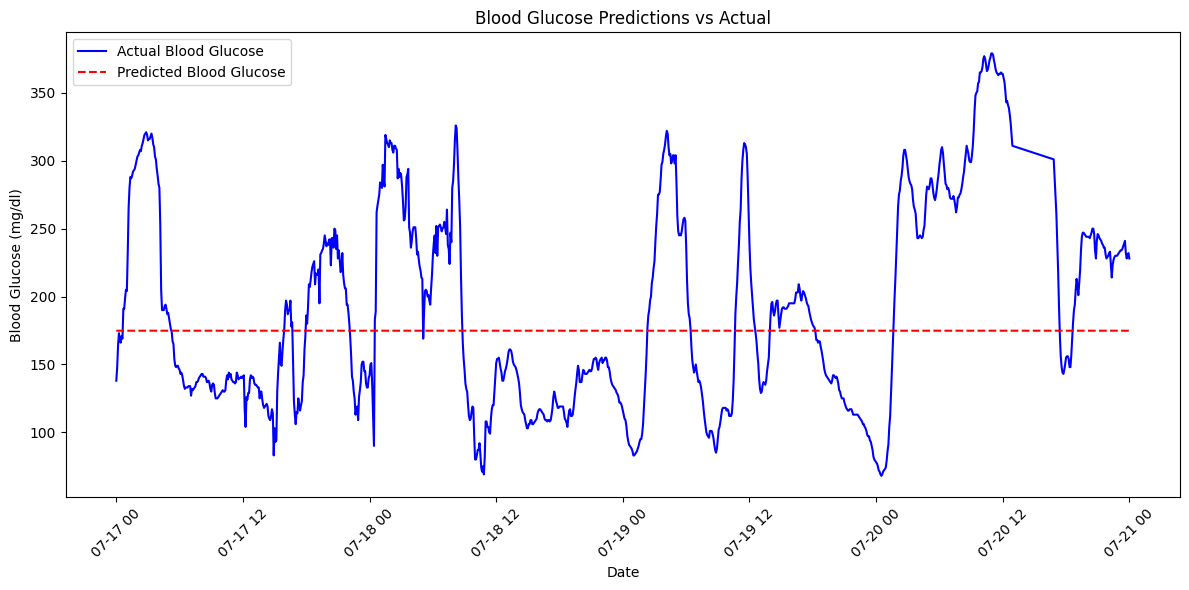

In [51]:
# Plot actual vs predicted for a specific week
def plot_predictions_for_week(data, predictions, actual, start_date, end_date):
    # Filter the test data for the specified week
    week_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)].reset_index(drop=True)

    # Get aligned predictions and actual values
    aligned_predictions = predictions[:len(week_data)]
    aligned_actual = actual[:len(week_data)]

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(week_data['date'], aligned_actual, label='Actual Blood Glucose', color='blue')
    plt.plot(week_data['date'], aligned_predictions, label='Predicted Blood Glucose', color='red', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Blood Glucose (mg/dl)')
    plt.title('Blood Glucose Predictions vs Actual')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for a specific week
plot_predictions_for_week(merged_data[train_size:], predictions, y_test, '2021-07-17', '2021-07-21')